# Implementation of ALEXNET

Source:

https://medium.com/analytics-vidhya/multi-class-image-classification-using-alexnet-deep-learning-network-implemented-in-keras-api-c9ae7bc4c05f

OR

https://medium.com/@syedsajjad62/alex-net-explanation-and-implementation-in-tensorflow-and-keras-8047efeb7a0f


### Import packages

In [1]:
import os
import io
import tensorflow as tf
import numpy as np
import pandas as pd
from azure.storage.blob import BlobServiceClient, ContainerClient
from PIL import Image
import matplotlib.pyplot as plt
import ast

2024-05-10 18:22:36.681623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Connect to Azure:

In [33]:
#set up storage
connection_string = "DefaultEndpointsProtocol=https;AccountName=mlfinalexam5505462853;AccountKey=0c40lghglG5/GlNK9yujDQAgo38GKoS2I3DeC/g22hwAEIFANKpmC/TqOpRk4RCT1DbfNiHBFt72+AStB+PfUA==;EndpointSuffix=core.windows.net"
container_name = "meterml"

#create client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

### Load images and paths

In [45]:
test = pd.read_csv("METER_ML_test.csv")
print(test.head())

                                       Image_Folder   Type  Type_encoded
0  samples/test_images/35.17852862_-79.99927082.png  CAFOs             0
1      samples/test_images/47.863317_-92.810639.png  CAFOs             0
2      samples/test_images/33.440833_-85.435833.png  CAFOs             0
3  samples/test_images/45.12488405_-94.24194995.png  CAFOs             0
4  samples/test_images/45.33317705_-94.50533971.png  CAFOs             0


In [46]:
df = pd.read_csv("METER_ML_test.csv")

#df = raw_df.sample(n=1000)

#filenames = df["Image_Folder"]
# convert each string in the DataFrame to a list
#df['Type_encoded'] = df['Type_encoded'].apply(ast.literal_eval)

# convert each list in the DataFrame to a numpy array
#df['labels'] = df['labels'].apply(np.array)

# store all the arrays in a list
#labels = df['labels'].tolist()

###train,test and validation split

In [18]:
#label_counts = df['labels'].value_counts()
#print(label_counts)

In [7]:
df_array = df.to_numpy()
print(df_array[:5])


[['samples/CAM_BACK_LEFT/n013-2018-09-03-15-16-32+0800__CAM_BACK_LEFT__1535959262647155.jpg'
  array([1, 0, 0, 0, 1, 1, 1])]
 ['samples/CAM_BACK_LEFT/n008-2018-05-30-16-31-36-0400__CAM_BACK_LEFT__1527712417047295.jpg'
  array([0, 0, 0, 0, 0, 0, 0])]
 ['samples/CAM_FRONT_LEFT/n015-2018-07-11-14-07-42+0800__CAM_FRONT_LEFT__1531289950604844.jpg'
  array([0, 0, 0, 0, 0, 0, 0])]
 ['samples/CAM_BACK/n008-2018-05-21-11-06-59-0400__CAM_BACK__1526915425187570.jpg'
  array([0, 0, 1, 0, 1, 1, 1])]
 ['samples/CAM_FRONT_LEFT/n008-2018-05-30-16-31-36-0400__CAM_FRONT_LEFT__1527713536855077.jpg'
  array([0, 0, 0, 0, 1, 0, 1])]]


### Train Test Split

In [47]:
# First Split:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(df['Image_Folder'], df['Type_encoded'], test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)


y_train = np.array(y_train).tolist()
y_val = np.array(y_val).tolist()
y_test = np.array(y_test).tolist()

print(len(X_train))
print(len(X_val))
print(len(X_test))

692
149
149


In [9]:
y_train = [arr[[1, 5, 6]] for arr in y_train]
y_val = [arr[[1, 5, 6]] for arr in y_val]
y_test = [arr[[1, 5, 6]] for arr in y_test]


### Set Variables

In [48]:
image_size=227
channels=3

batch_size = 224 # Big enough to measure an F1-score
autotune = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
shuffle_buffer_size = 1024 # Shuffle the training data by a chunck of 1024 observations

### Functions to creat data input for models

In [49]:
def load_image(path):
    """Load an image from Azure Blob Storage."""
    blob_client = container_client.get_blob_client(path)
    blob_data = blob_client.download_blob().readall()  # Directly read all bytes
    return io.BytesIO(blob_data)

def load_and_preprocess_image(path):
    """Loads an image, decodes it to grayscale, resizes, and normalizes it."""
    # Load image
    image_file = load_image(path.numpy().decode('utf-8'))
    # Decode the image to grayscale
    image_tensor = tf.io.decode_image(image_file.getvalue(), channels=channels)
    # Resize the image
    image_resized = tf.image.resize(image_tensor, [image_size, image_size])
    # Normalize the image data
    image_normalized = image_resized / 255.0
    return image_normalized


def process_tensor(path, label):
    """Function to load an image from blob storage, decode, resize, and normalize it."""
    image_normalized = tf.py_function(load_and_preprocess_image, [path], tf.float32)
    # Ensure the shape is set correctly for grayscale
    image_normalized.set_shape([image_size, image_size, channels])
    return image_normalized, label

def create_dataset(filenames, labels, is_training=True):
    """Creates a TensorFlow dataset from filenames and labels."""
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(process_tensor, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=1024)
        
    dataset = dataset.batch(256)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

### Create Data Set

In [50]:
train_ds = create_dataset(X_train, y_train, is_training=True)
val_ds = create_dataset(X_val, y_val, is_training=False)
test_ds = create_dataset(X_test, y_test, is_training=False)

### Print Data Set

In [23]:
for images, labels in train_ds.take(1):  # Here, take(1) takes the first batch
    print("Images:", images.numpy())  # Convert tensor to numpy array and print
    print("Labels:", labels.numpy())  # Convert tensor to numpy array and print

2024-05-10 18:38:38.559375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 207 of 1024
2024-05-10 18:38:48.550532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 432 of 1024
2024-05-10 18:38:58.605618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 659 of 1024
2024-05-10 18:39:00.014686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Images: [[[[0.62294245 0.52453744 0.44644296]
   [0.61214244 0.50997615 0.42570135]
   [0.28340065 0.29324123 0.32543   ]
   ...
   [0.6117408  0.52010226 0.37437803]
   [0.60242814 0.49085286 0.35949573]
   [0.37401477 0.37605307 0.2999743 ]]

  [[0.6118264  0.50788885 0.44668564]
   [0.2717584  0.26687875 0.29466742]
   [0.56734884 0.58873606 0.5908545 ]
   ...
   [0.62810355 0.5098018  0.3679753 ]
   [0.49892223 0.42723227 0.3346952 ]
   [0.6097356  0.49554262 0.36899772]]

  [[0.2595709  0.2806018  0.26522422]
   [0.51382256 0.5507989  0.5307117 ]
   [0.6921028  0.6821672  0.6557959 ]
   ...
   [0.5161632  0.43295312 0.3334002 ]
   [0.60510826 0.49330282 0.3562882 ]
   [0.65783644 0.5671111  0.41335157]]

  ...

  [[0.14098428 0.17016709 0.19607843]
   [0.13850516 0.16862746 0.19607843]
   [0.13893928 0.16862746 0.19776276]
   ...
   [0.2116088  0.21529289 0.24938864]
   [0.24023883 0.23720743 0.259727  ]
   [0.4591148  0.41450983 0.38818854]]

  [[0.14016569 0.16571668 0.19215687]

### Plot one image from the data set

2024-05-10 18:52:56.147510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 188 of 1024
2024-05-10 18:53:06.157345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 414 of 1024
2024-05-10 18:53:16.171606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 612 of 1024
2024-05-10 18:53:20.112245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


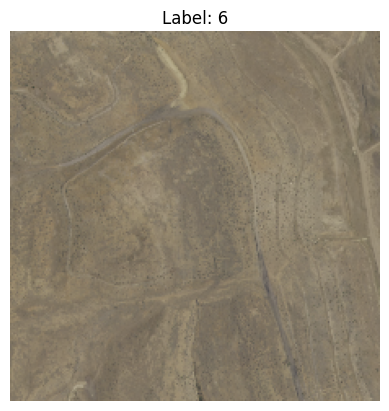

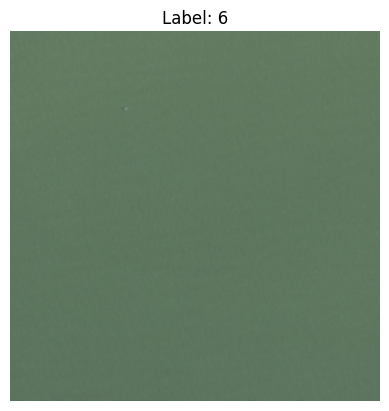

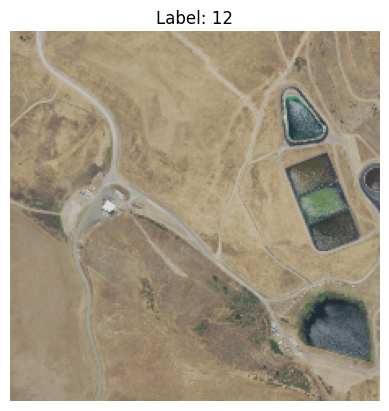

In [40]:
def plot_first_image_from_dataset(dataset, index):
    # Take one batch from the dataset
    for images, labels in dataset.take(index):
        # Assuming the image tensor is in the shape [batch_size, height, width, channels]
        # and you need the first image in the batch
        first_image = images[0]  # This is a tensor

        # Check if the image needs to be squeezed (in case it's a grayscale image with a single channel)
        if first_image.shape[-1] == 1:
            first_image = tf.squeeze(first_image, axis=-1)
        
        # Convert tensor to numpy for plotting
        first_image_np = first_image.numpy()

        # Plot the image
        plt.imshow(first_image_np, cmap='gray')
        plt.title(f'Label: {labels[0].numpy()}')
        plt.axis('off')
        plt.show()

# Example usage with your train_ds dataset
plot_first_image_from_dataset(train_ds,7)

### Implement ALEXNET in KERAS two possible implementations

In [51]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential()

# Layer 1: Convolutional layer with 64 filters of size 11x11x3
model.add(Conv2D(filters=64, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', input_shape=(227,227,3)))

# Layer 2: Max pooling layer with pool size of 3x3
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Layer 3-5: 3 more convolutional layers with similar structure as Layer 1
model.add(Conv2D(filters=192, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Layer 6: Fully connected layer with 4096 neurons
model.add(Flatten())
model.add(Dense(4096, activation='relu'))

# Layer 7: Fully connected layer with 4096 neurons
model.add(Dense(7, activation='softmax'))

In [52]:
# Compile train model
LR = 1e-5
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [43]:
# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 55, 55, 64)        23296     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 27, 27, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 27, 27, 192)       307392    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 13, 13, 192)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 384)       663936    
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 256)      

### Define Class Weights

In [24]:
# Count ones funciton:
def count_ones(arrays):
    counts = [0] * len(arrays[0])  # Initialize counts with zeros
    
    for array in arrays:
        for i, num in enumerate(array):
            if num == 1:
                counts[i] += 1
    
    return counts

In [25]:
# Define weights:
total_samples = sum(count_ones(y_train))
class_0_samples = count_ones(y_train)[0]
class_1_samples = count_ones(y_train)[1]
class_2_samples = count_ones(y_train)[2]

print(f"Total samples: {total_samples}")
print(f"Class 0 samples: {class_0_samples}")
print(f"Class 1 samples: {class_1_samples}")
print(f"Class 2 samples: {class_2_samples}")

Total samples: 787
Class 0 samples: 112
Class 1 samples: 486
Class 2 samples: 189


In [32]:
weight_0 = 10
weight_1 = total_samples / (2 * class_1_samples)
weight_2 = 6

print(f"Weight 0: {weight_0}")
print(f"Weight 1: {weight_1}")
print(f"Weight 2: {weight_2}")

Weight 0: 10
Weight 1: 0.8096707818930041
Weight 2: 6


In [53]:
# Fit Model:
fit = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-05-10 18:56:26.155924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 249 of 1024
2024-05-10 18:56:36.161126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 478 of 1024
2024-05-10 18:56:45.859782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


3/3 [==============================] - 68s 12s/step - loss: 1.9282 - accuracy: 0.2934 - val_loss: 1.8823 - val_accuracy: 0.4094
Epoch 2/10
3/3 [==============================] - 32s 12s/step - loss: 1.8597 - accuracy: 0.4350 - val_loss: 1.8279 - val_accuracy: 0.4094
Epoch 3/10
3/3 [==============================] - 31s 11s/step - loss: 1.7983 - accuracy: 0.4350 - val_loss: 1.7862 - val_accuracy: 0.4094
Epoch 4/10
3/3 [==============================] - 31s 11s/step - loss: 1.7524 - accuracy: 0.4350 - val_loss: 1.7713 - val_accuracy: 0.4094
Epoch 5/10
3/3 [==============================] - 31s 11s/step - loss: 1.7389 - accuracy: 0.4350 - val_loss: 1.7885 - val_accuracy: 0.4094
Epoch 6/10
3/3 [==============================] - 31s 11s/step - loss: 1.7515 - accuracy: 0.4350 - val_loss: 1.8016 - val_accuracy: 0.4094
Epoch 7/10
3/3 [==============================] - 34s 12s/step - loss: 1.7471 - accuracy: 0.4350 - val_loss: 1.7910 - val_accuracy: 0.4094
Epoch 8/10
3/3 [======================

In [54]:
# get predicitons:
predictions = model.predict(train_ds)

3/3 [==============================] - 8s 2s/step


In [55]:
predictions

array([[0.10226335, 0.13177034, 0.10808934, ..., 0.13235219, 0.1330805 ,
        0.13137753],
       [0.08171927, 0.11299658, 0.08356056, ..., 0.1202815 , 0.11942823,
        0.12410139],
       [0.08415371, 0.12094921, 0.08932046, ..., 0.1224967 , 0.1247594 ,
        0.12303345],
       ...,
       [0.06827571, 0.10829925, 0.07320541, ..., 0.10825667, 0.11435589,
        0.11204499],
       [0.08546644, 0.12070243, 0.09108732, ..., 0.12354013, 0.12511684,
        0.12753306],
       [0.08278664, 0.12230575, 0.08773798, ..., 0.12284737, 0.12480184,
        0.1218935 ]], dtype=float32)

In [56]:
# Check predicitons and actual labels:
for images, labels in train_ds:
    predictions = model.predict(images)  # Only pass image data
    #print(predictions[:1])
    for pred, label in zip(predictions, labels):
        print("Prediction:", pred, "Actual Label:", label.numpy())# Print the first prediction
    break

8/8 [==============================] - 3s 325ms/step
Prediction: [0.07062898 0.11083952 0.07774784 0.3941071  0.11350012 0.11548664
 0.11768973] Actual Label: 3
Prediction: [0.08315728 0.11979257 0.08909643 0.3393078  0.12280288 0.12272599
 0.1231171 ] Actual Label: 3
Prediction: [0.08171927 0.11299658 0.08356056 0.35791233 0.1202815  0.11942823
 0.12410139] Actual Label: 3
Prediction: [0.0612973  0.10355666 0.06620853 0.44627687 0.10504139 0.1101104
 0.10750887] Actual Label: 5
Prediction: [0.08346941 0.11738364 0.08667894 0.3447196  0.12278444 0.12306329
 0.12190077] Actual Label: 0
Prediction: [0.08522318 0.11980174 0.08639928 0.34265202 0.12225518 0.12443409
 0.11923461] Actual Label: 0
Prediction: [0.0950774  0.1280319  0.09994034 0.28874308 0.13016714 0.12980646
 0.12823366] Actual Label: 1
Prediction: [0.07684498 0.11677324 0.08415201 0.3635513  0.1194725  0.12035608
 0.1188499 ] Actual Label: 4
Prediction: [0.08817122 0.12046042 0.09105609 0.32793322 0.12396091 0.12355571
 0.12